# Carla vehicle throttle-brake control
This is a brief demonstration of how to control carla vehicle based on throttle and brake. The codes is almost the same as the [throttle-only-control](https://github.com/CenturyLiu/Carla-Project-Speed-Control/blob/master/draft/throttle_only_control.ipynb), except that I add brake torque to the vehicle if the vehicle is decelerating.

### Part 1: Prerequisites for using the code below
Follow instruction on [python-control](https://python-control.readthedocs.io/en/0.8.3/intro.html#), install the python control package.

### Part 2: Control system design

According to the [carla vehicle control document](https://carla.readthedocs.io/en/latest/python_api/#carla.VehicleControl), a carla vehicle's speed can be controlled by throttle, brake and gear. For simplicity, I only implemented the control with throttle. For more detailed car-control model, see [python-control example: cruise control](https://python-control.readthedocs.io/en/0.8.3/cruise.html).

Here is a block diagram of the control system.
[block diagram](https://github.com/CenturyLiu/Carla-Project-Speed-Control/blob/master/draft/block_diagram.PNG)

The system is a simple unity feedback loop control system, with a "controller" block, and a "vehicle" block.

The "vehicle" block in the diagram represents the carla vehicle we want to control. The vehicle takes the throttle input, use the throttle value interacting with the environment and report its forward.  

The "controller" block is the one we need to design. Here, I implemented a simple block PI controller.


### Part 3: Code walk through
- Block 1: import all packages needed

In [1]:
%matplotlib inline

import carla
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import time

import control # the python-control package, install first
from carla_env import CARLA_ENV # self-written class that provides help functions, should be in the same folder

- Block 2: create a PI controller 

In [2]:
# PI controller constants
KI = 0.01
KP = 0.5

def get_PI_controller(delta_seconds):
    '''
    Effects: create a discrete state-space PI controller
    '''
    num_pi = [KP, KI] # numerator of the PI transfer function (KP*s + KI)
    den_pi = [1.0, 0.01*KI/KP] # denominator of PI transfer function (s + 0.01*KI/KP)

    sys = control.tf(num_pi,den_pi) # get transfer function for PI controller (since the denominator has a small term 0.01*KI/KP, it is actually a lag-compensator)
    sys = control.sample_system(sys, delta_seconds) # discretize the transfer function (from s-domain which is continuous to z-domain)
                                                        #since our simulation is discrete
    sys = control.tf2ss(sys) # transform transfer function into state space.
    return sys

# example
sys = get_PI_controller(0.02)
sys

A = [[0.999996]]

B = [[0.01]]

C = [[0.01979996]]

D = [[0.5]]

dt = 0.02

- define the functions for applying the throttle-only controller                                                    
This function *throttle_brake_control* is currently for one vehicle. It seems ok to adapt this function and make it possible for controlling the speed for multiple vehicles.

In [3]:
def speed_control(sys, ref_speeds, curr_speeds, init_values):
    '''
    Effects: get the reference speed, current (measured) speed and initial values
             Use the difference 
                               e = ref_speeds - curr_speeds 
             as the input for the PI controller, derive the new throttle

    Parameters
    ----------
    sys : control.ss 
        state space controller 
    ref_speeds : list of float
        the desired speed we need
    curr_speeds : list of float
        the current speed
    init_values : the initial_values of the system
        DESCRIPTION.

    Returns
    -------
    throttle : float type
        DESCRIPTION.

    '''
    U0 = np.array(ref_speeds) - np.array(curr_speeds)
    #print(U0)
    _,y0,x0 = control.forced_response(sys,U = U0,X0 = init_values[0]) # y0 is the next values, x0 is the state evolution
                                                                      # see https://python-control.readthedocs.io/en/0.8.3/generated/control.forced_response.html#control.forced_response 
    init_values.append(x0[-1])
    throttle = y0[-1]
    return throttle, init_values



def throttle_brake_control(env, speed_timeline, sim_time, model_uniquename):
    '''
    Effects: this is the function where the whole control system in part 2 is implemented. 
    -------
    
    Parameters:
    -----------
    env: CARLA_ENV
    
    speed_timeline: a list of tuples of (time (unit: s), speed (unit: m/s)).
        Example: [(1,25),(10,10),(20,15)] 
                 The car will start accelerate from 0 to 25 m/s (90 km/h) at t = 1
                 And decelerate from 25 m/s to 10 m/s at t = 10
                 And accelerate again from 10 m/s to 15m/s at t = 15
                 
    sim_time: Total time for simulation. Its value should be larger than the last time in the speed_timeline list
    
    model_uniquename: str type
        The uniquename the vehicle, which was assigned when an actor is spawned
       
    '''
    
    
    
    # essential storages for the controller to work
    init_values = deque(maxlen = 2) # the state space values of the system. For a control system to be fully functional
                                    # we need to give initial value
    ref_speeds = deque(maxlen = 2) # the reference / target speed
    curr_speeds = deque(maxlen = 2) # the measured speed of the vehicle
    
    
    # storage for the visualize the reference speed, throttle and measured speed.
    speed = []
    throttles = []
    reference_speed = []
    
    # give initial values to storage, assume the car is released at rest, with no initial speed or acceleration
    init_values.append(0) 
    ref_speeds.append(0)
    curr_speeds.append(0)
    
    count = 0 #timestep count
    end_t = int(sim_time / env.delta_seconds) #the time at which the simulation ends
    
    timeline = [(st[0] / env.delta_seconds, st[1]) for st in speed_timeline] 
    timeline_count = 0 
    current_ref_speed = 0
    
    
    while True: #loop for applying control
        env.world.tick()
        curr_speed = env.get_forward_speed(model_uniquename)
        speed.append(curr_speed)
        
        if count >= end_t:
            break
            
        if timeline_count < len(timeline):
            if count >= timeline[timeline_count][0]:  # need to get a new reference speed
                current_ref_speed = timeline[timeline_count][1]
                timeline_count += 1
        
        reference_speed.append(current_ref_speed) #for visualization
        ref_speeds.append(current_ref_speed) #for control
        curr_speeds.append(curr_speed) #for control
        
        throttle, init_values = speed_control(sys, ref_speeds, curr_speeds, init_values) # get the throttle control based on reference and current speed
        throttle = np.clip(throttle,0,1) # throttle value is [0,1]
        throttles.append(throttle) # for visualization
        
        if curr_speed <= current_ref_speed:
            vehicle_control = carla.VehicleControl(throttle = throttle,steer=0.0) 
        else:
            vehicle_control = carla.VehicleControl(throttle = throttle,steer=0.0,brake = 0.5)
        env.apply_vehicle_control(model_uniquename, vehicle_control) # apply control to vehicle
        
        count += 1
        # end loop
        
        
    return throttles, speed, reference_speed
    

- demo of the throttle-brake-control on a plain ground

destroyed all actors


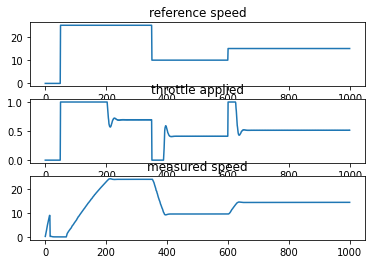

In [4]:
client = carla.Client("localhost",2000)
client.set_timeout(10.0)
world = client.load_world('Town06')

# set the spectator position for demo purpose
spectator = world.get_spectator()
spectator.set_transform(carla.Transform(carla.Location(x=-68.29, y=151.75, z=170.8), carla.Rotation(pitch=-31.07, yaw= -90.868, roll=1.595))) # plain ground

env = CARLA_ENV(world) 
time.sleep(2) # sleep for 2 seconds, wait the initialization to finish

# spawn a vehicle, here I choose a Tesla model
spawn_point = carla.Transform(carla.Location(x=-277.08, y=-15.39, z=4.94), carla.Rotation(pitch=0.000000, yaw= 0, roll=0.000000))
model_name = "vehicle.tesla.model3"
model_uniquename = env.spawn_vehicle(model_name,spawn_point) # spawn the model and get the uniquename, the CARLA_ENV class will store the vehicle into vehicle actor list

#create timeline and sim_time
sim_time = 20
speed_timeline = [(1,25),(7,10),(12,15)]

try:

    throttles, speed, reference_speed = throttle_brake_control(env, speed_timeline, sim_time, model_uniquename)
    
    fig,a =  plt.subplots(3,1)
    
    #plt.subplot(3,1,1)
    a[0].plot(reference_speed)
    a[0].set_title('reference speed')
    #plt.subplot(3,1,2)
    a[1].plot(throttles)
    a[1].set_title('throttle applied')
    a[2].plot(speed)
    a[2].set_title('measured speed')
    
    
finally:
    env.destroy_actors()

### Part 4 Discussion
This implementation adds brake torque to the vehicle. The deceleration is more efficient this way compare with the throttle-only version: [throttle-only-control-plot](https://github.com/CenturyLiu/Carla-Project-Speed-Control/blob/master/draft/change_speed_90_36_64.8.png)

Shiji Liu
6/14/2020